In [26]:
from utils.parser_utils import *
# from parser_run import *
from utils.evaluate import evaluate_metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
parsers = [
    # non-LLM parsers
    # "Drain",
    # "ULP",
    # "Brain",
    # "Logram",
    # "AEL",
    # unsupervised parsers
    "LLM_TD",
    "LogBatcher",
    "LogPrompt",
    "OpenLogParser",
    "SelfLog",
    # supervised parsers
    "DivLog-2",
    "DivLog-4",
    "LILAC-4",
    "LILAC-2",
]

non_llm_parsers = sorted(["Drain", "Brain", "ULP", "AEL", "SPELL"]) #"Logram", 

datasets = [
    'Android',
    'Apache',
    'BGL',
    'HDFS',
    'HPC',
    'Hadoop',
    'HealthApp',
    'Linux',
    'Mac',
    'OpenSSH',
    'OpenStack',
    'Proxifier',
    'Spark',
    'Thunderbird',
    'Windows',
    'Zookeeper',
    "Audit" # custom
]

total_runs = 3

params = {
    "in_dir": DATA_FOLDER + "2k/",
    "dataset_type": "2k",
    "log_format": True,
}

In [28]:
def evaluate(model, multiple_runs_list, datasets, parsers, corrected_LogHub=True, no_whitespace=[]):
    str_add = "_corrected_LogHub" if corrected_LogHub else "_LogHub"
    limit = 2000
    for dataset in datasets:
        input_dir = params["in_dir"]
        for parser in parsers:
            print(f"--- {dataset} - {parser}", flush=True)
            corrected_str = "_corrected" if corrected_LogHub else ""
            groundtruth_path = os.path.join(input_dir, dataset, f"{dataset}_{params["dataset_type"]}.log_structured{corrected_str}.csv")
            results_runs = []
            for run in range(1,total_runs+1):
                run_dir = f"run{run}" if parser in multiple_runs_list else ""
                out_dir = os.path.join(OUTPUT_FOLDER, model, parser, run_dir)
                result_path = os.path.join(out_dir, f"{dataset}_{params["dataset_type"]}.log_structured.csv")
                #result_path = os.path.join(OUTPUT_FOLDER, parser, f"{dataset}_{params["dataset_type"]}.log_structured.csv")
                if not os.path.exists(result_path):
                    print("Path doesn't exist:", result_path)
                    continue
                if parser in no_whitespace:
                    df_result = evaluate_metrics(dataset, groundtruth_path, result_path, limit=limit, no_whitespace=True)
                else:
                    df_result = evaluate_metrics(dataset, groundtruth_path, result_path, limit=limit, no_whitespace=False)
                # display(df_result)
                if df_result is None:
                    print("Skipping")
                    continue
                summary_path = os.path.join(out_dir, f"_summary{str_add}.csv")
                if not os.path.exists(summary_path):
                    df_result.to_csv(summary_path, index=False)
                else:
                    df_result.to_csv(summary_path, index=False, mode="a", header=False)
                
                if parser not in multiple_runs_list:
                    break
                results_runs.append(df_result.set_index("Dataset"))

            if parser not in multiple_runs_list:
                continue
            df_results_runs = reduce(lambda x, y: x.add(y, fill_value=0), results_runs)/total_runs
            summary_path = os.path.join(OUTPUT_FOLDER, model, parser, f"_summary{str_add}.csv")
            if not os.path.exists(summary_path):
                df_results_runs.to_csv(summary_path, index=True)
            else:
                df_results_runs.to_csv(summary_path, index=True, mode="a", header=False)

def get_results(model, parsers, corrected_LogHub=True, exclude=[]):
    parsers_list = [p for p in parsers if p not in exclude]
    dfs = []
    str_add = "_corrected_LogHub" if corrected_LogHub else "_LogHub"
    for i, parser in enumerate(parsers_list):
        path = os.path.join(OUTPUT_FOLDER, model, parser, f"_summary{str_add}.csv")
        try:
            df_res = pd.read_csv(path).drop_duplicates(subset=["Dataset"], keep="last").set_index("Dataset")
            dfs.append(df_res[["GA","FTA","PA","NED"]])
        except Exception as e:
            print(f"Error: {e}")
            continue
    df_full = pd.concat(dfs, axis=1, keys=parsers_list)
    #pd.set_option("display.max_columns", None)
    #display(df_full.round(3))
    return df_full

def plot(df, parsers, exclude=[], save_path=None, ylim=(-0.02,1.02)):
    #parsers_list = [p for p in parsers if p not in exclude]
    dataframes = [df[p] if p not in exclude else df[parsers[0]].map(lambda x: -1) for p in parsers]

    plt.rcParams.update({'font.size': 8.5})
    fig, axes = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(11/9*(len(dataframes)), 2.5), sharey=True)
    for ax, df_, title in zip(axes, dataframes, parsers):
        sns.boxplot(data=df_, ax=ax)
        ax.set_title(title)
    
    plt.ylim(ylim)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def plot_bar(df, parsers, exclude=[], width=11, height=3, save_path=None):
    parsers_list = [p for p in parsers if p not in exclude]
    dataframes = [df[p] for p in parsers_list]
    plt.rcParams.update({'font.size': 8.5})
    fig, axes = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(width/9*len(parsers_list), height), sharey=True)
    for ax, df_, title in zip(axes, dataframes, parsers_list):
        sns.barplot(data=df_, ax=ax)
        ax.set_title(title)
    #plt.ylim((-0.02,1.02))
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def plot_bar_stacked(df, parsers, exclude=[], width=11, height=3, save_path=None):
    parsers_list = [p for p in parsers if p not in exclude]
    dataframes = [df[p] for p in parsers_list]
    plt.rcParams.update({'font.size': 8.5})
    n_cols = len(dataframes) // 2 + len(dataframes) % 2  # Calculate number of columns for two rows
    fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(width/9*n_cols, height * 2), sharey=True)
    axes = axes.flatten()  # Flatten axes for easier iteration
    for ax, df_, title in zip(axes, dataframes, parsers_list):
        sns.barplot(data=df_, ax=ax)
        ax.set_title(title)
    # Hide any unused subplots
    for ax in axes[len(dataframes):]:
        ax.axis('off')
    plt.ylim((-0.02, 1.02))
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


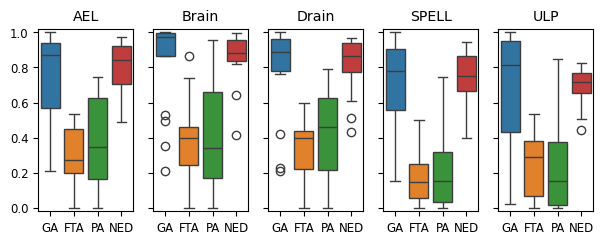

In [29]:
# evaluate("no-LLM", non_llm_parsers, datasets, non_llm_parsers, corrected_LogHub=True, no_whitespace=["ULP"])
df_no_llm = get_results("no-LLM", non_llm_parsers, corrected_LogHub=True)
plot(df_no_llm, non_llm_parsers, save_path="plots/no_llm.pdf")

In [30]:
# evaluate("codellama:7b-instruct", parsers, datasets, parsers, corrected_LogHub=True)
df_codellama = get_results("codellama:7b-instruct", parsers, corrected_LogHub=True)
# evaluate("gpt-3.5-turbo", parsers, datasets, parsers, corrected_LogHub=True)
df_gpt = get_results("gpt-3.5-turbo", parsers, corrected_LogHub=True)
# evaluate("gpt-3.5-turbo_LogHub", parsers, datasets, parsers, corrected_LogHub=False)
df_gpt_uncorrected = get_results("gpt-3.5-turbo_LogHub", parsers, corrected_LogHub=False)
# p_list = parsers.copy()
# p_list.remove("LogPrompt")
# evaluate("deepseek-ai/DeepSeek-R1", p_list, datasets, p_list, corrected_LogHub=True)
df_deepseek = get_results("deepseek-ai/DeepSeek-R1", parsers, exclude=["LogPrompt"], corrected_LogHub=True)

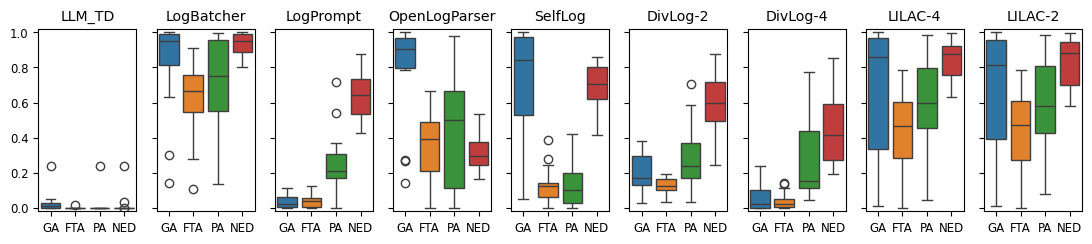

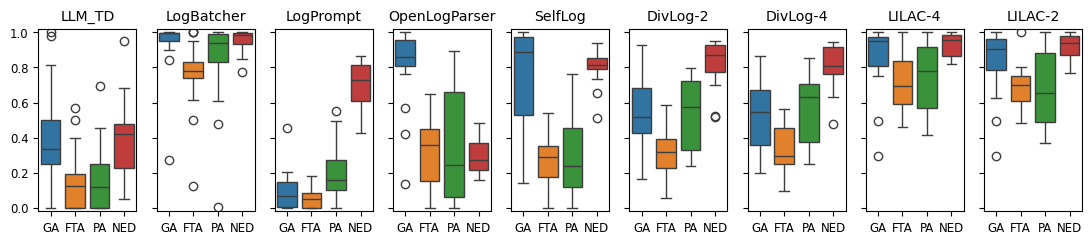

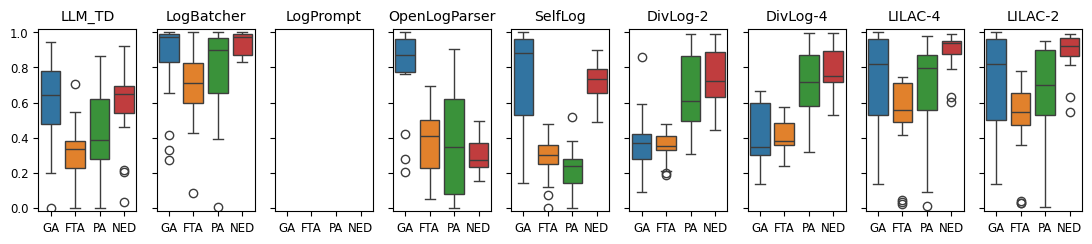

In [31]:
plot(df_codellama, parsers, save_path="plots/codellama.pdf")
plot(df_gpt, parsers, save_path="plots/gpt.pdf")
# plot(df_gpt_uncorrected, parsers, save_path="plots/gpt_uncorrected.pdf")
plot(df_deepseek, parsers, exclude=["LogPrompt"], save_path="plots/deepseek.pdf")

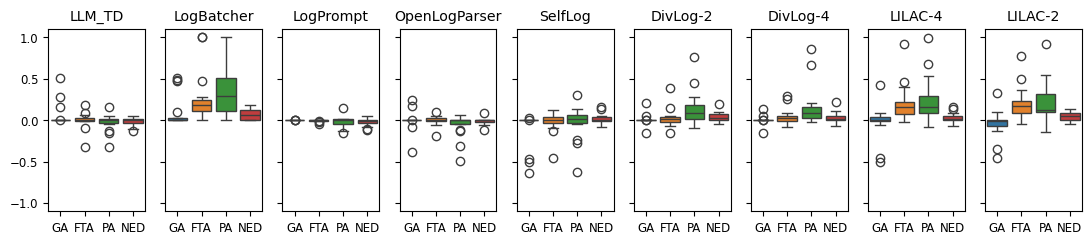

In [32]:
df_diff = (df_gpt.drop(index="Audit")-df_gpt_uncorrected.drop(index="Audit"))
plot(df_diff, parsers, save_path="plots/gpt_minus_gpt_uncorrected.pdf", ylim=(-1.1,1.1))

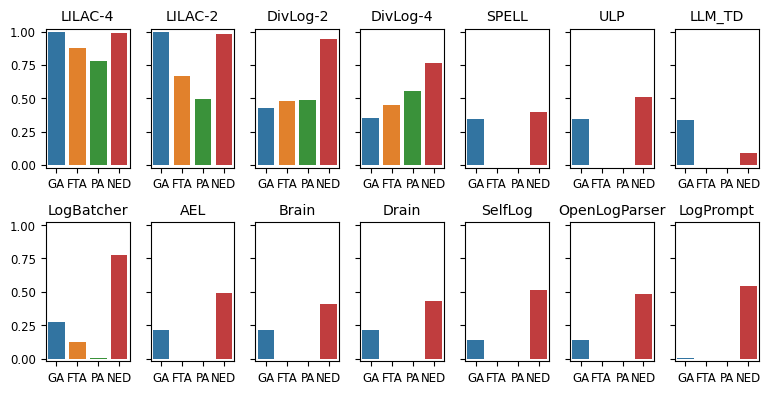

In [33]:
df_gpt_incl_non_llm_parser = pd.concat([df_no_llm, df_gpt], axis=1)
sorted_columns = df_gpt_incl_non_llm_parser.loc["Audit"].loc[:,"GA"].sort_values(ascending=False).index
df_sorted = df_gpt_incl_non_llm_parser[sorted_columns]
plot_bar_stacked(pd.DataFrame(df_sorted.loc["Audit"]).T, sorted_columns, width=10, height=2, save_path="plots/gpt_incl_no_llm_audit.pdf")

In [48]:
# df_gpt_ = df_gpt.copy()
# df_gpt_.columns = pd.MultiIndex.from_tuples([(f"{col[0]}-GPT", col[1]) for col in df_gpt.columns])
# df_codellama_ = df_codellama.copy()
# df_codellama_.columns = pd.MultiIndex.from_tuples([(f"{col[0]}-CL", col[1]) for col in df_codellama.columns])
# df_deepseek_ = df_deepseek.copy()
# df_deepseek_.columns = pd.MultiIndex.from_tuples([(f"{col[0]}-DS", col[1]) for col in df_deepseek.columns])

# df_all_incl_non_llm_parser = pd.concat([df_no_llm, df_gpt_, df_codellama_, df_deepseek_], axis=1)
# sorted_columns = df_all_incl_non_llm_parser.loc["Audit"].loc[:,"GA"].sort_values(ascending=False).index
# df_sorted = df_all_incl_non_llm_parser[sorted_columns]
# plot_bar_stacked(pd.DataFrame(df_sorted.loc["Audit"]).T, sorted_columns, width=12, height=2, save_path="plots/all_models_incl_no_llm_audit.pdf")

In [36]:
# print table with best performances in bold
tmp = df_gpt_incl_non_llm_parser.T.copy()
tmp["Average"] = tmp.mean(axis=1).round(2)
table = tmp.T.round(2).copy()

def check_decimal(x):
    if len(x) != 4:
        return x + "0"
    else:
        return x

for d in datasets + ["Average"]:
    for m in ["GA", "FTA", "PA", "NED"]:
        values = {p: table.loc[d, (p, m)] for p in non_llm_parsers + parsers}
        max_value = max(values.values())
        best_parsers = [p for p, v in values.items() if v == max_value]

        for best_parser in best_parsers:
            table.loc[d, (best_parser, m)] = r"\textbf{" + check_decimal(str(table.round(2).loc[d, (best_parser, m)])) + r"}"
table

/tmp/ipykernel_9795/203615315.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.97}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[d, (best_parser, m)] = r"\textbf{" + check_decimal(str(table.round(2).loc[d, (best_parser, m)])) + r"}"
/tmp/ipykernel_9795/203615315.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.78}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.loc[d, (best_parser, m)] = r"\textbf{" + check_decimal(str(table.round(2).loc[d, (best_parser, m)])) + r"}"
/tmp/ipykernel_9795/203615315.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.83}' has dtype incompatible with float64, please exp

AEL                            Brain              \
                        GA   FTA    PA   NED             GA   FTA    PA   
Dataset                                                                   
Android               0.77  0.46  0.39  0.90           0.86  0.37  0.24   
Apache       \textbf{1.00}  0.50  0.69  0.92  \textbf{1.00}  0.67  0.70   
BGL                   0.96  0.22  0.34  0.84  \textbf{0.99}  0.24  0.41   
HDFS         \textbf{1.00}  0.53  0.62  0.93  \textbf{1.00}  0.87  0.96   
HPC                    0.9  0.46  0.68  0.97           0.94  0.46  0.66   
Hadoop                0.87  0.24  0.51  0.70           0.95  0.20  0.16   
HealthApp             0.57  0.10  0.16  0.56  \textbf{1.00}  0.40  0.25   
Linux                  0.4  0.27  0.17  0.74           0.35  0.40  0.17   
Mac                   0.76  0.17  0.17  0.71  \textbf{0.94}  0.33  0.34   
OpenSSH               0.54  0.23  0.25  0.92  \textbf{1.00}  0.23  0.28   
OpenStack             0.25  0.08  0.02  0.60           0.49  0.21  0.11   
Proxifier             0.97  0.44  0.67  0.97           0.53  0.74  0.70   
Spark                  0.9  0.28  0.38  0.71  \textbf{1.00}  0.44  0.38   
Thunderbird           0.94  0.20  0.04  0.71  \textbf{0.97}  0.34  0.04   
Windows               0.69  0.27  0.15  0.90  \textbf{1.00}  0.45  0.46   
Zookeeper             0.92  0.45  0.75  0.92  \textbf{0.99}  0.57  0.78   
Audit                 0.21  0.00  0.00  0.49           0.21  0.00  0.00   
Average               0.74  0.29  0.35  0.79           0.84  0.41  0.39   

                                    Drain        ... DivLog-4        \
                       NED             GA   FTA  ...       PA   NED   
Dataset                                          ...                  
Android               0.84           0.83  0.54  ...     0.50  0.78   
Apache                0.92  \textbf{1.00}  0.50  ...     0.70  0.91   
BGL                   0.84           0.96  0.22  ...     0.67  0.93   
HDFS         \textbf{1.00}  \textbf{1.00}  0.60  ...     0.71  0.87   
HPC                   0.88           0.89  0.39  ...     0.53  0.63   
Hadoop                0.64           0.95  0.30  ...     0.32  0.69   
HealthApp             0.88           0.78  0.11  ...     0.76  0.91   
Linux                 0.82           0.42  0.40  ...     0.38  0.81   
Mac                   0.86           0.79  0.20  ...     0.36  0.78   
OpenSSH               0.95           0.79  0.44  ...     0.65  0.95   
OpenStack    \textbf{0.96}           0.22  0.02  ...     0.25  0.48   
Proxifier             0.97           0.76  0.41  ...     0.85  0.91   
Spark                 0.96           0.92  0.40  ...     0.77  0.93   
Thunderbird           0.82           0.96  0.25  ...     0.27  0.64   
Windows      \textbf{0.92}  \textbf{1.00}  0.41  ...     0.63  0.80   
Zookeeper             0.94           0.97  0.52  ...     0.79  0.93   
Audit                 0.41           0.21  0.00  ...     0.56  0.77   
Average               0.86           0.79  0.34  ...     0.57  0.81   

                   LILAC-4                                               \
                        GA            FTA             PA            NED   
Dataset                                                                   
Android               0.95           0.66           0.57           0.85   
Apache       \textbf{1.00}  \textbf{1.00}  \textbf{1.00}  \textbf{1.00}   
BGL                   0.98  \textbf{0.89}  \textbf{0.96}  \textbf{0.99}   
HDFS                  0.94           0.46           0.53           0.82   
HPC          \textbf{0.95}  \textbf{0.75}           0.92           0.99   
Hadoop                0.97           0.59           0.83           0.95   
HealthApp             0.91            0.8           0.89           0.96   
Linux                  0.3            0.7           0.42           0.92   
Mac                   0.81           0.47  \textbf{0.49}           0.86   
OpenSSH               0.75  \textbf{0.84}           0.7

In [37]:
# print to latex
tab = table.T
tab = tab.rename(index={c: r"\textbf{" + str(c) + r"}" for c in tab.index})
tab = tab.rename(columns={c: r"\begin{turn}{90}{" + str(c) + r"}\end{turn}" for c in tab.columns})
print(tab.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllllllllllllll}
\toprule
 & Dataset & \begin{turn}{90}{Android}\end{turn} & \begin{turn}{90}{Apache}\end{turn} & \begin{turn}{90}{BGL}\end{turn} & \begin{turn}{90}{HDFS}\end{turn} & \begin{turn}{90}{HPC}\end{turn} & \begin{turn}{90}{Hadoop}\end{turn} & \begin{turn}{90}{HealthApp}\end{turn} & \begin{turn}{90}{Linux}\end{turn} & \begin{turn}{90}{Mac}\end{turn} & \begin{turn}{90}{OpenSSH}\end{turn} & \begin{turn}{90}{OpenStack}\end{turn} & \begin{turn}{90}{Proxifier}\end{turn} & \begin{turn}{90}{Spark}\end{turn} & \begin{turn}{90}{Thunderbird}\end{turn} & \begin{turn}{90}{Windows}\end{turn} & \begin{turn}{90}{Zookeeper}\end{turn} & \begin{turn}{90}{Audit}\end{turn} & \begin{turn}{90}{Average}\end{turn} \\
\midrule
\multirow[t]{4}{*}{AEL} & GA & 0.77 & \textbf{1.00} & 0.96 & \textbf{1.00} & 0.90 & 0.87 & 0.57 & 0.40 & 0.76 & 0.54 & 0.25 & 0.97 & 0.90 & 0.94 & 0.69 & 0.92 & 0.21 & 0.74 \\
 & FTA & 0.46 & 0.50 & 0.22 & 0.53 & 0.46 & 0.24 & 0.10 & 0.27 & 0.17 & 0.23 & 0.

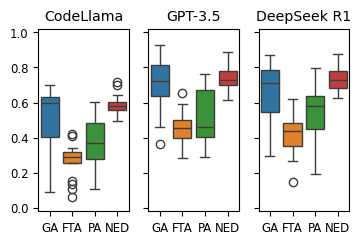

In [38]:
# plot results per LLM
def extract(df):
    parsers_list = [p for p in parsers if p not in ["LogPrompt"]] # exclude LogPrompt
    return sum([df[p] for p in parsers_list])/len(parsers_list)

dfs = {"CodeLlama": extract(df_codellama), "GPT-3.5": extract(df_gpt), "DeepSeek R1": extract(df_deepseek)}

plot(dfs, dfs.keys(), save_path="plots/all_models_aggregated.pdf")

In [39]:
# prepare plots for efficiency evaluation
import warnings
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index")

def get_time_eval(df, parsers, sort_by="Computation Time"):
    if sum(df["run"] != 2) != 0:
        print("Number of runs not equal to 3!")  # safety check
    total_mean = [df.loc[p]["total_runtime"].mean() for p in parsers]
    total_std = [df.loc[p]["total_runtime"].std() for p in parsers]
    invoc_mean = [df.loc[p]["invocation_time"].mean() for p in parsers]
    invoc_std = [df.loc[p]["invocation_time"].std() for p in parsers]
    comp_mean = [(df.loc[p]["total_runtime"] - df.loc[p]["invocation_time"]).mean() for p in parsers]
    comp_std = [(df.loc[p]["total_runtime"] - df.loc[p]["invocation_time"]).std() for p in parsers]
    columns = pd.MultiIndex.from_tuples([
        ('Computation Time', r'$\mu$'),
        ('Computation Time', r'$\sigma$'),
        ('Invocation Time', r'$\mu$'),
        ('Invocation Time', r'$\sigma$'),
        ('Total Runtime', r'$\mu$'),
        ('Total Runtime', r'$\sigma$'),
    ])
    data = [[comp_mean[i], comp_std[i], invoc_mean[i], invoc_std[i], total_mean[i], total_std[i]] for i in range(len(total_mean))]
    time_df = pd.DataFrame(data, columns=columns, index=parsers)
    return time_df.sort_values(by=(sort_by, r'$\mu$'), ascending=False).round(2)

def get_time_table(model, parsers, datasets, folder=None, ):
    if folder:
        df_time_raw = pd.read_csv(os.path.join(folder, model, "times.csv"))
    else:
        df_time_raw = pd.read_csv(os.path.join(OUTPUT_FOLDER, model, "times.csv"))
    df_time_raw = df_time_raw.sort_values(by=["parser","dataset","run"])
    df_time = df_time_raw[df_time_raw['dataset'] != 'Audit-light']#.groupby(['parser', "dataset"]).tail(3)
    tmp_list = []
    # use for loop because groupby does weird things ...
    for parser in parsers:
        for dataset in datasets:
            for run in range(1, total_runs + 1):
                tmp = df_time[df_time["parser"] == parser]
                tmp = tmp[df_time["dataset"] == dataset]
                tmp = tmp[df_time["run"] == run].tail(1)
                tmp_list.append(tmp)
    df_time_avg = pd.concat(tmp_list)
    df_time_avg = df_time_avg.groupby(['parser', "dataset"])[["run","total_runtime","invocation_time","n_queries"]].sum().apply(lambda x: x/total_runs)
    return df_time_avg

runtime_parsers = [
    "Drain",
    "ULP",
    "Brain",
    "SPELL",
    "AEL",
    "OpenLogParser",
    # "LogPrompt",
    "LLM_TD",
    "LogBatcher",
    # "SelfLog", # SelfLog got killed
    "LILAC-2",
    "LILAC-4",
]

df_time_bgl = get_time_table("gpt-3.5-turbo", runtime_parsers, datasets=["BGL"], folder="output-full/")
time_table_bgl = get_time_eval(df_time_bgl, parsers=runtime_parsers, sort_by="Computation Time")
df_time_hdfs = get_time_table("gpt-3.5-turbo", runtime_parsers, datasets=["HDFS"], folder="output-full/")
time_table_hdfs = get_time_eval(df_time_hdfs, parsers=runtime_parsers, sort_by="Computation Time")

['#b40426', '#f49a7b', '#dcdddd', '#8caffe', '#3b4cc0']


/tmp/ipykernel_9795/3220836126.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


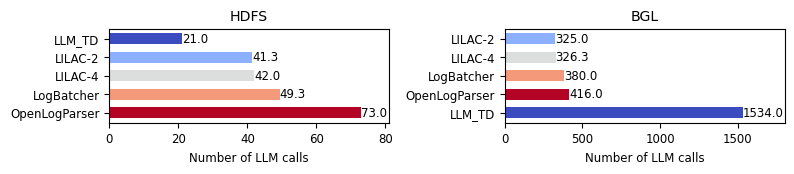

In [40]:
# plot number of queries
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1, 2, figsize=(8, 1.8))

df_q_hdfs = df_time_hdfs["n_queries"].drop(index=non_llm_parsers).reset_index().set_index("parser")
q_series_hdfs = df_q_hdfs["n_queries"].sort_values(ascending=False)
df_q_bgl = df_time_bgl["n_queries"].drop(index=non_llm_parsers).reset_index().set_index("parser")
q_series_bgl = df_q_bgl["n_queries"].sort_values(ascending=False)

# Generate gradient colors
def get_gradient_colors(n, cmap_name="coolwarm_r"):  # 'coolwarm' goes from blue to red
    cmap = cm.get_cmap(cmap_name)
    return [mcolors.to_hex(cmap(i / (n - 1))) for i in range(n)]

c = get_gradient_colors(len(q_series_hdfs))
print(c)

# Plot HDFS
q_series_hdfs.plot(kind="barh", color=c, width=0.6, ax=axes[0])
for i, nq in enumerate(q_series_hdfs):
    axes[0].text(nq, i, f"{nq:.1f}", va="center", ha="left", color="black")

# Plot BGL
q_series_bgl.plot(kind="barh", color=[c[4], c[0], c[1], c[2], c[3]], width=0.6, ax=axes[1])
for i, nq in enumerate(q_series_bgl):
    axes[1].text(nq, i, f"{nq:.1f}", va="center", ha="left", color="black")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[0].set_title("HDFS")
axes[1].set_title("BGL")
axes[0].set_xlim((0, 81))
axes[1].set_xlim((0, 1800))
axes[0].set_xlabel("Number of LLM calls")
axes[1].set_xlabel("Number of LLM calls")
plt.tight_layout()
plt.savefig("plots/n_queries_HDFS_BGL.pdf")
plt.show()



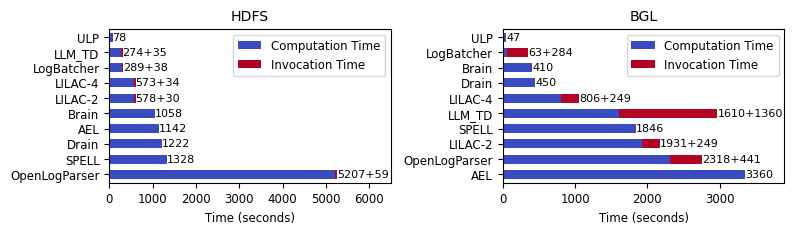

In [41]:
# plot time evaluation
import matplotlib.pyplot as plt

def time_plot(ax, time_table, xlim=None, title=""):
    bars = time_table[[("Computation Time", r"$\mu$"), ("Invocation Time", r"$\mu$")]].plot(
        kind="barh", stacked=True, ax=ax, colormap="coolwarm", width=0.6
    )
    # Add text annotations for each bar
    for i, (comp_time, invoc_time) in enumerate(zip(time_table[("Computation Time", r"$\mu$")], time_table[("Invocation Time", r"$\mu$")])):
        if invoc_time > 0:
            ax.text(comp_time + invoc_time, i, f"{int(round(comp_time, 0))}+{invoc_time:.0f}", va="center", ha="left", color="black", fontsize=8,)
        else:
            ax.text(comp_time, i, f"{int(round(comp_time, 0)):.0f}", va="center", ha="left", color="black", fontsize=8,)

    ax.set_xlabel("Time (seconds)")
    #ax.set_ylabel("Parsers")
    ax.legend(["Computation Time", "Invocation Time"])
    ax.set_xlim(xlim)
    ax.set_title(title)

# Create a single figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 2.4))

# Plot each dataset in its respective subplot
time_plot(axes[1], time_table_bgl, xlim=(0, 3900), title="BGL")
time_plot(axes[0], time_table_hdfs, xlim=(0, 6500), title="HDFS")

plt.tight_layout()
plt.savefig("plots/time_HDFS_BGL.pdf")
plt.show()
